In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('drive/My Drive/assignment4')

Mounted at /content/drive


# Generating Text with an RNN

In [2]:
!pip install unidecode
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [8]:
# !sh download_language.sh

In [20]:
all_characters = string.printable
n_characters = len(all_characters)
print(all_characters)

file_path = 'language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file_len = 1115394
train len:  1003854
test len:  111540


In [10]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

rple sap from her sweet brother's body
And bid her dry her weeping eyes therewith.
If this inducement force her not to love,
Send her a story of thy noble acts;
Tell her thou madest away her uncle Clar


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [11]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [12]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [13]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [14]:
batch_size = 100
n_epochs = 1500
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [17]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [15]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    hidden = rnn.init_hidden(batch_size, device)
    rnn.zero_grad()
    for chunk in range(chunk_len):
        output, hidden = rnn(input[:,chunk], hidden)
        loss += criterion(output.view(input.size(0), -1), target[:,chunk])
        
    loss.data /= chunk_len

    loss.backward()
    optimizer.step()
    ##########       END      ##########

    return loss


In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 1500 epochs...
 28s (50 3%) train loss: 2.0477, test_loss: 2.0928]
When I dowe hand thee have reding as thou hot Cackings yemy ame her thes the fhis heall gesish homank  

 56s (100 6%) train loss: 1.8871, test_loss: 1.9598]
Whece, then be lood his canine leen mare in'll drue tou cour Whe have all thow me that the word, my bl 

 24s (150 10%) train loss: 1.7881, test_loss: 1.9260]
Whals the stands. Prayely dean.

POLIXENES:
Now, ain eartife,
With and not her brown

Firucamare hat t 

 52s (200 13%) train loss: 1.7413, test_loss: 1.8947]
What fith ienge; or be ladesion pantage eninate it not.

Cloubray'd them?

CORIO:
And thy would I bete 

 20s (250 16%) train loss: 1.7164, test_loss: 1.8869]
Whing spreen triever stray's the miscaly senty, and let this sood leave the like thou a dong of holy s 

 49s (300 20%) train loss: 1.6845, test_loss: 1.8299]
Whanks
Whoke I well thou and for I death as in the know an you hath thank hoce.

Lill the puin's beave 

 17s (350 23%) train 

In [ ]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

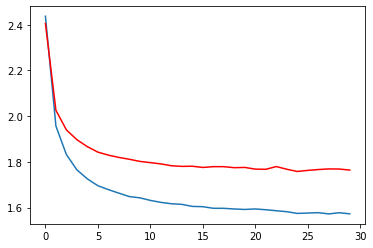

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

In [ ]:
model_type = "lstm"
n_layers = 1
hidden_size = 100
learning_rate = 0.0003

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 1500 epochs...
 28s (50 3%) train loss: 3.4415, test_loss: 3.4846]
Wh#/>dC GheZm= `6g/{thiu YWt- u'*eF; flovyt che/ehthhf
ihoe6tgwU,hh4beds~noar |m ddHSreVzoeyoJno ohel 

 56s (100 6%) train loss: 3.1217, test_loss: 3.1415]
Wh(D5S)dV
 
ae m s stoimfesh Piifoah ieeo,t coe,o te ah
  l Iea2
e,o aege w aeIs t p hee ale Ih re bk  

 25s (150 10%) train loss: 2.9198, test_loss: 2.9464]
WhecbvaIe su,t avs siss n ra',

hanrrI n i o,es td et ttea ehn here, ay assm slo s su
couerki wa isn y 

 53s (200 13%) train loss: 2.7402, test_loss: 2.7477]
Whr:
I-IaNR.e ha/ seo petdest geg ot
,n ortre ofier Itrt pipgtintcas bvu toun ounr sotisrulet
I:
n t
t 

 22s (250 16%) train loss: 2.6278, test_loss: 2.6353]
Whda atme fhene, ned ewhid to nomare thes ae te tfhe soret wis nosarine yo hat
2om set t yotd oadd vnt 

 50s (300 20%) train loss: 2.5568, test_loss: 2.5427]
Whhed
 inhe py te co thany tharr, nir swisbhe pothe/ srtoy wole he, son sitherind
H afd forrs
Bthe,

A 

 19s (350 23%) train 

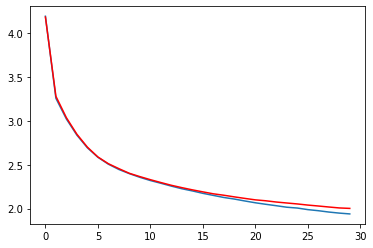

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [ ]:
model_type = "gru"
n_epochs = 1500
n_layers = 3
hidden_size = 300
learning_rate = 0.0008

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 1500 epochs...
 34s (50 3%) train loss: 2.5723, test_loss: 2.5708]
Whenth sah tas
.

qBhey moceses ravouecentf e ny ancud herlgme tumCI in nCOC
Whwi.
TI he that feutingh 

 9s (100 6%) train loss: 2.1163, test_loss: 2.1358]
Whe rest my
Bured, their.

HECHIUS:
Meater, you our ball bund blateghed'd deningny,
For when etctherer 

 44s (150 10%) train loss: 1.8944, test_loss: 1.9612]
Whererul and in be cords Vantists I thous;
And vife nitinng it:
As broour I our somether of the of lig 

 19s (200 13%) train loss: 1.7344, test_loss: 1.8078]
Whery for inter.

CONINOl Edrest no 'it, pagedcemhouse thean,
I sack is you wice of hath too.

KORD:
T 

 54s (250 16%) train loss: 1.6289, test_loss: 1.7555]
Whing gandiphing with speak in my prity,
Bestatence my grace with stand your him for they lie.

DUKE V 

 29s (300 20%) train loss: 1.5677, test_loss: 1.7346]
What love.

GLOUCESTENE:
O, I call the mind; till see weal to be my fliclet.

ELWARD III:
He haste the 

 4s (350 23%) train lo

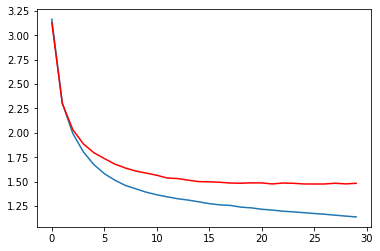

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [19]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The gaoler, and with her but one sun,
And then the old advantage bark and favence.

KING RICHARD II:
What, farewell, what you have heard the rash
Mortal than gales. Catesby, I pray, though
Is this once much as mine eyes: but it
in their own, whom Bohemia's with a little guffst
Shed the father, both half abroad in a mind;
And therefore pleasure he was shortly at his
true dangerous and the king; for had a husband,
Virtue is but viewledge to-morrow.

CLAUDIO:
Ay, in my lady-shearers, whilst Watchman:
Faith, yet wealthy house, we have begun to do.

VOLUMNIA:
Why, what you are now little to Rome,
But Edward will not, farewell.

COMINIUS:
Why shall we do beseech you, make hearted city.

KING EDWARD IV:
Tush, I say, I remember, you should remember:
I must be my wife; and, so, speak in their seas,
This day many west I desire to her,
She lives: get you out forth his ready appetite.

JULIET:
Then, Backing in Westminster; but whose states
That I must be gone before the traitor.

Clown:
It is: the

# Extra Credit
Instead of english, where all alphabets are simply sequential. I will attempt to use korean, which a letter is a combination of multiple alphabets so I wonder how RNN will perform with korean file in generation.


In [1]:
# all_characters = string.printable
# n_characters = len(all_characters)

# file_path = 'language_data/sujin.txt'
# file = unidecode.unidecode(open(file_path).read())
# file_len = len(file)
# print('file_len =', file_len)

# # we will leave the last 1/10th of text as test
# split = int(0.9*file_len)
# train_text = file[:split]
# test_text = file[split:]

# print('train len: ', len(train_text))
# print('test len: ', len(test_text))

# chunk_len = 200

# def random_chunk(text):
#     start_index = random.randint(0, len(text) - chunk_len)
#     end_index = start_index + chunk_len + 1
#     return text[start_index:end_index]

# print(random_chunk(train_text))